# 1팀 최종 보고서

## 목차

1. 개요

2. 데이터셋 통찰\
2.1 데이터셋 선정 및 분석\
&emsp;2.1.1 데이터셋 선정\
&emsp;2.1.2 데이터셋 분석\
2.2 데이터셋 전처리\
&emsp;2.2.1 데이터셋 추출\
&emsp;2.2.2 데이터셋 병합\
&emsp;2.2.3 문제점 및 해결 방안

3. 모델 선정\
3.1 Mask R-CNN\
&emsp;3.1.1 모델 데모\
&emsp;3.1.2 훈련\
3.2 Detectron2\
&emsp;3.2.1 모델 데모\
&emsp;3.2.2 훈련

4. 모델 파인튜닝\
4.1 파인튜닝 방향 설정\
4.2 데이터셋 증강\
&emsp;4.2.1 yolo segmentation 증강\
&emsp;4.2.2 기존 bbox 기반 yolo segmentation 증강\
4.3 모델 훈련\
&emsp;4.3.1 yolo segmentation 증강 훈련\
&emsp;4.3.2 기존 bbox기반의 yolo segmentation 증강 훈련\
4.4 훈련 결과 지표 비교\
4.5 추론 이미지, 영상 비교\
4.6 문제점 분석

5. 서비스 구현\
5.1 서비스 개발 방향 설정\
5.2 서비스 구현 코드

6. 최종 모델 평가

## 1. 개요

이 프로젝트는 이미지 처리 및 객체 인식을 활용한 주차 공간 탐지에 관한 프로젝트로 이제까지 부트캠프 과정에서 학습한 이미저 처리 및 객체 인식 기술들을 구현에 보기 위해 진행되었다. Mask R-CNN 과 Detectron을 비교하고 Yolov8 을 이용해 증강한 데이터를 통해 fine tuning을 진행하여 모델의 성능을 개선하는 것을 목적으로 한다. 또한, 더 나아가 개선시킨 모델을 이용해 서비스를 구현하는 것을 목표로 하였다. (어떤 서비스인지, 서비스를 통해 얻고자 하는 바 추가 작성)

## 2. 데이터셋 통찰

### 2.1 데이터셋 선정 및 분석

#### 2.1.1 데이터셋 선정

AI-Hub에서 주차관련 데이터들의  어노테이션 포맷을 참고하여 공간탐지에 적합한 segmentation이 있는 데이터셋 선정하였고 최종적으로 "주차 공간 탐색을 위한 차량 관점 복합 데이터"를 선택하였다.
- https://www.aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=data&dataSetSn=598

#### 2.1.2 데이터셋 분석

##### 데이터 개요

- 메타에이터 구조표
     
    <img src="./final_image/data_structure.jpg" width="800" height="200">
        
- 어노테이션 포맷

    <img src="./final_image/anotation_format.png" width="800" height="1200">

- 데이터 구축 규모 : 290.36 GB

    <img src="./final_image/data_size.jpg" width="800" height="300">


##### 어노테이션 포멧 분석

1) 로컬에서 라벨링데이터 가져오기\
powerShell에서 scp -r "C:\elicetrain\088.주차공간탐색을위한차량관점복합데이터\01.데이터\1.Training\라벨링데이터\실내\중소형주차장" elicer@14.35.173.14:/home/elicer/jyj/ 로 진행
        
2) class 파악\
ex) TL2실내중소형주차장

In [ ]:
import os
import json

# JSON 파일들이 있는 폴더 경로
json_folder_path = '/home/elicer/jyj/ms_parking'

# 모든 JSON 파일에서 label과 class 정보를 추출하는 함수
def count_labels_and_classes(json_folder_path):
    bbox2d_class_count = {}
    segmentation_class_count = {}

    for root, dirs, files in os.walk(json_folder_path):
        for file in files:
            if file.endswith('.json'):
                file_path = os.path.join(root, file)
                with open(file_path, 'r') as f:
                    data = json.load(f)

                    # bbox2d 내의 "name"을 추출하여 bbox2d_class_count에 저장
                    for bbox in data.get("bbox2d", []):
                        class_name = bbox.get("name")
                        if class_name:
                            bbox2d_class_count[class_name] = bbox2d_class_count.get(class_name, 0) + 1

                    # segmentation 내의 "name"을 추출하여 segmentation_class_count에 저장
                    for seg in data.get("segmentation", []):
                        class_name = seg.get("name")
                        if class_name:
                            segmentation_class_count[class_name] = segmentation_class_count.get(class_name, 0) + 1

    return bbox2d_class_count, segmentation_class_count

# 함수 호출 및 결과 출력
bbox2d_class_count, segmentation_class_count = count_labels_and_classes(json_folder_path)

# 각 class별로 빈도 출력
print("bbox2d Classes and Counts:")
for class_name, count in bbox2d_class_count.items():
    print(f'Class: {class_name}, Count: {count}')

print("\nsegmentation Classes and Counts:")
for class_name, count in segmentation_class_count.items():
    print(f'Class: {class_name}, Count: {count}')

# 총 클래스 수 출력
print(f"\nTotal bbox2d Classes: {len(bbox2d_class_count)}")
print(f"Total segmentation Classes: {len(segmentation_class_count)}")


##### Segmentaion 데이터 파악
        
ex) TL2실내중소형주차장 파일에서 진행

In [ ]:
base_path = u'/home/elicer/jyj/ms_parking'
folders = [f'ms_parking_{str(i).zfill(3)}' for i in range(1, 57)]
label_folders = [os.path.join(base_path, folder, 'label') for folder in folders]

# 모든 JSON 데이터를 저장할 리스트
all_data = []

# 각 폴더의 label 폴더 안에 있는 모든 JSON 파일을 읽어서 합치기
for label_folder in label_folders:
    for json_file in os.listdir(label_folder):
        if json_file.endswith('.json'):
            json_path = os.path.join(label_folder, json_file)
            with open(json_path, 'r') as f:
                data = json.load(f)
                all_data.append(data)

##### 합쳐진 데이터를 데이터프레임으로 변환

In [ ]:
# 합쳐진 데이터를 데이터프레임으로 변환
df = pd.DataFrame(all_data)
df

In [ ]:
empty_segmentation = df[df['segmentation'].apply(lambda x: len(x) != 0)]
print(empty_segmentation)

##### 바운딩 박스 2D, 3D, 세그먼테이션 데이터 개수 추출

In [ ]:
# 모든 bbox2d, bbox3d, segmentation 데이터를 저장할 리스트
bbox2d_data = []
bbox3d_data = []
segmentation_data = []

# 각 폴더의 label 폴더 안에 있는 모든 JSON 파일을 읽어서 합치기
for label_folder in label_folders:
    for json_file in os.listdir(label_folder):
        if json_file.endswith('.json'):
            json_path = os.path.join(label_folder, json_file)
            with open(json_path, 'r') as f:
                data = json.load(f)

                # bbox2d 데이터 추출
                for bbox2d in data.get('bbox2d', []):
                    bbox2d_entry = {
                        'image': data['image'],
                        'name': bbox2d.get('name'),
                        'occluded': bbox2d.get('occluded'),
                        'bbox': bbox2d.get('bbox'),
                        'status': bbox2d.get('status', None)  # 'status'가 있을 경우에만 가져옴
                    }
                    bbox2d_data.append(bbox2d_entry)

                # segmentation 데이터 추출
                for seg in data.get('segmentation', []):
                    seg_entry = {
                        'image': data['image'],
                        'name': seg.get('name'),
                        'size' : seg.get('size'),
                        'pattern' : seg.get('pattern'),
                        'polygon': seg.get('polygon'),
                    }
                    segmentation_data.append(seg_entry)

In [ ]:
df_bbox2d = pd.DataFrame(bbox2d_data)
df_bbox3d = pd.DataFrame(bbox3d_data)
df_segmentation = pd.DataFrame(segmentation_data)

##### 바운딩 박스 클래스 개수 파악

In [ ]:
print(len(df_bbox2d['name'].unique()))

In [ ]:
df_bbox2d['name'].value_counts()

##### 바운딩 박스 개수 시각화

In [ ]:
name_counts = df_bbox2d['name'].value_counts()

plt.figure(figsize=(8, 5))
name_counts.plot(kind='bar')
plt.title('BBox2d Object Counts by Name')
plt.xlabel('Object Name')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

##### 바운딩 박스와 세그먼테이션 시각화

In [ ]:
name_counts_bbox2d = df_bbox2d['name'].value_counts()
name_counts_segmentation = df_segmentation['name'].value_counts()

# 두 개의 시리즈를 하나의 데이터프레임으로 결합
name_counts_combined = pd.DataFrame({
    'bbox2d': name_counts_bbox2d,
    'segmentation': name_counts_segmentation
}).fillna(0)  # NaN 값을 0으로 채우기

# 합계로 정렬하기 위해 합계를 새로운 열로 추가
name_counts_combined['total'] = name_counts_combined.sum(axis=1)

# 총합을 기준으로 내림차순 정렬
name_counts_combined = name_counts_combined.sort_values(by='total', ascending=False)

# 총합 열 제거 (그래프에 필요 없으므로)
name_counts_combined = name_counts_combined.drop(columns=['total'])

# 그래프 그리기
plt.figure(figsize=(12, 8))
name_counts_combined.plot(kind='bar')

# 그래프 제목 및 축 레이블 설정
plt.title('Counts by Name (bbox2d and segmentation)')
plt.xlabel('Object/Segmentation Name')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')

# 레이아웃 조정 및 그래프 출력
plt.tight_layout()
plt.show()


##### 데이터셋 시각화

**<실내 중소형주차장>**

실내중소형주차장(TL2) :  Total bbox2d Classes: 34 / Total segmentation Classes: 2

<img src="./final_image/TL2_count.png" width="600" height="400">

실내중소형주차장(TL3) :  Total bbox2d Classes: 35 / Total segmentation Classes: 2

<img src="./final_image/TL3_count.png" width="600" height="400">

---

**<실외 중소형주차장>**

실외중소형주차장 :  Total bbox2d Classes: 37 / Total segmentation Classes: 3

- segmentation Classes에 bbox2d 클래스인 Parking Block이 검출됨
    
    라벨링 오류로 추측

<img src="./final_image/실외중소형_count.png" width="600" height="400">

---

**<실내 대형주차장>**

실내대형주차장 :  Total bbox2d Classes: 35 / Total segmentation Classes: 2

- 한글로된 폴더명 경로인식이 안됨 → 폴더명 모두 영어로 바꿈

<img src="./final_image/실내대형_count.png" width="600" height="400">

---

**<실외 대형주차장>**

실외대형주차장 :  Total bbox2d Classes: 35 / Total segmentation Classes: 2

<img src="./final_image/실외대형_count.png" width="600" height="400">

---

**<실외 일반도로>**

실외일반도로 :  Total bbox2d Classes: 34 / Total segmentation Classes: 0

<img src="./final_image/실외일반_count.png" width="600" height="400">

---

**<실외 노상>**

실외노상 :  Total bbox2d Classes: 31 / Total segmentation Classes: 2

<img src="./final_image/실외노상_count.png" width="600" height="400">

##### 이미지별 Segmentaion 갯수 파악
ex) TL2실내중소형주차장

In [ ]:
import os
import pandas as pd
import json

# 기본 경로 설정
base_path = "/home/elicer/jyj/중소형주차장_segmentation_only"
directories = os.listdir(base_path)

# DataFrame 초기화
df = pd.DataFrame(columns=["Parking Space Count", "Driveable Space Count"])

# 모든 노상 폴더 순회
for dir_name in directories:
    dir_path = os.path.join(base_path, dir_name, "label")
    
    if os.path.isdir(dir_path):
        files = os.listdir(dir_path)
        
        # 모든 JSON 파일 순회
        for file_name in files:
            if file_name.endswith(".json"):
                file_path = os.path.join(dir_path, file_name)
                
                # JSON 파일 읽기
                with open(file_path, 'r', encoding='utf-8') as file:
                    data = json.load(file)
                
                # Parking Space와 Driveable Space의 개수를 세는 변수
                parking_space_count = 0
                driveable_space_count = 0
                
                # Segmentation 리스트를 순회하며 각 공간의 이름을 확인
                for segment in data.get('segmentation', []):
                    if segment['name'] == 'Parking Space':
                        parking_space_count += 1
                    elif segment['name'] == 'Driveable Space':
                        driveable_space_count += 1
                
                # 행 이름 설정 (노상 번호와 파일 이름)
                row_name = f"{dir_name}_{file_name}"
                
                # DataFrame에 추가
                df.loc[row_name] = [parking_space_count, driveable_space_count]

In [ ]:
df

In [ ]:
# Parking Space Count가 0인 데이터 이름 리스트
parking_zero_list = df[df['Parking Space Count'] == 0].index.tolist()

# Driveable Space Count가 0인 데이터 이름 리스트
driveable_zero_list = df[df['Driveable Space Count'] == 0].index.tolist()


In [ ]:
pd.DataFrame(parking_zero_list)

In [ ]:
pd.DataFrame(driveable_zero_list)

### 2.2 데이터셋 전처리

#### 2.2.1 데이터셋 추출

라벨데이터 Segmentation 추출\
ex)L2실내중소형주차장

In [ ]:
import os
import json

# JSON 파일들이 있는 폴더 경로
json_folder_path = '/home/elicer/jyj/중소형주차장'
output_folder_path = '/home/elicer/jyj/중소형주차장_segmentation_only'

# 새로운 JSON 파일로 저장하는 함수 및 크기 비교
def save_segmentation_only_json(json_folder_path, output_folder_path):
    # 출력 폴더가 없으면 생성
    os.makedirs(output_folder_path, exist_ok=True)

    original_total_size = 0
    reduced_total_size = 0

    for root, dirs, files in os.walk(json_folder_path):
        for file in files:
            if file.endswith('.json'):
                file_path = os.path.join(root, file)
                original_total_size += os.path.getsize(file_path)  # 원본 파일 크기 합산

                with open(file_path, 'r') as f:
                    data = json.load(f)

                    # segmentation이 있는 경우에만 파일 생성
                    if "segmentation" in data and data["segmentation"]:
                        # 불필요한 항목들 제거
                        data.pop("bbox2d", None)
                        data.pop("calib", None)
                        data.pop("bbox3d", None)

                        # 새로운 JSON 파일로 저장
                        relative_path = os.path.relpath(root, json_folder_path)
                        output_dir = os.path.join(output_folder_path, relative_path)
                        os.makedirs(output_dir, exist_ok=True)
                        output_file_path = os.path.join(output_dir, file)
                        with open(output_file_path, 'w') as output_file:
                            json.dump(data, output_file, indent=4)
                        
                        print(f'파일 생성됨: {output_file_path}')
                        reduced_total_size += os.path.getsize(output_file_path)  # 변환된 파일 크기 합산

    return original_total_size, reduced_total_size

# 함수 호출
original_size, reduced_size = save_segmentation_only_json(json_folder_path, output_folder_path)

# 크기 비교 출력
reduction_percentage = 100 * (original_size - reduced_size) / original_size if original_size > 0 else 0
print(f"원본 데이터셋 크기: {original_size / (1024 * 1024):.2f} MB")
print(f"축소된 데이터셋 크기: {reduced_size / (1024 * 1024):.2f} MB")
print(f"데이터셋 축소 비율: {reduction_percentage:.2f}%")


##### 라벨데이터로 이미지데이터 축소
ex) TL2실내중소형주차장

In [ ]:
import os
import shutil
import json

# JSON 파일들이 있는 폴더 경로
json_folder_path = r"C:\elicetrain\088.주차공간탐색을위한차량관점복합데이터\01.데이터\1.Training\라벨링데이터\실내\중소형주차장_segmentation_only"
image_source_folder = r"C:\elicetrain\088.주차공간탐색을위한차량관점복합데이터\01.데이터\1.Training\원천데이터\실내\중소형주차장"
image_destination_folder = r"C:\elicetrain\088.주차공간탐색을위한차량관점복합데이터\01.데이터\1.Training\원천데이터\실내\중소형주차장_segmentation"

# JSON 파일과 매칭되는 이미지 파일을 로컬에 복사하는 함수
def copy_matching_images(json_folder_path, image_source_folder, image_destination_folder):
    # 출력 폴더가 없으면 생성
    os.makedirs(image_destination_folder, exist_ok=True)

    for root, dirs, files in os.walk(json_folder_path):
        for file in files:
            if file.endswith('.json'):
                json_file_path = os.path.join(root, file)
                print(f'Processing JSON file: {json_file_path}')  # 디버깅 출력을 추가
                try:
                    with open(json_file_path, 'r') as f:
                        data = json.load(f)

                        # 이미지 파일명을 JSON에서 추출하면서 모든 공백 제거
                        image_file_name = data.get("image", "").strip().replace(" ", "")
                        print(f'Extracted image file name: {image_file_name}')  # 디버깅 출력을 추가

                        # 경로에서 추가적으로 필요한 정보를 붙임
                        if image_file_name:
                            # JSON 파일의 부모 디렉토리 이름 가져오기
                            json_parent_dir = os.path.basename(os.path.dirname(root))

                            # 이미지의 실제 경로 구성
                            image_source_path = os.path.join(image_source_folder, json_parent_dir, image_file_name)
                            image_destination_path = os.path.join(image_destination_folder, json_parent_dir, image_file_name)

                            print(f'Source image path: {image_source_path}')  # 디버깅 출력을 추가
                            print(f'Destination image path: {image_destination_path}')  # 디버깅 출력을 추가

                            # 이미지 파일이 존재하면 복사
                            if os.path.exists(image_source_path):
                                os.makedirs(os.path.dirname(image_destination_path), exist_ok=True)
                                shutil.copy2(image_source_path, image_destination_path)
                                print(f'이미지 파일 복사됨: {image_source_path} -> {image_destination_path}')
                            else:
                                print(f'이미지 파일이 존재하지 않음: {image_source_path}')
                        else:
                            print('Image file name is empty or not found in JSON')

                except json.JSONDecodeError as e:
                    print(f"JSONDecodeError in file {json_file_path}: {e}")
                except Exception as e:
                    print(f"An error occurred with file {json_file_path}: {e}")

# 함수 호출
copy_matching_images(json_folder_path, image_source_folder, image_destination_folder)

print("모든 이미지 파일이 성공적으로 복사되었습니다.")

##### 축소 결과
실내중소형주차장(TL2) :  

- 원본 데이터셋 크기: 52.10 GB , 93,222 장

- 축소된 데이터셋 크기: 6.21 GB , 8,175 장

실내중소형주차장(TL3) :  

- 원본 데이터셋 크기: 85.0 GB , 94,613 장

- 축소된 데이터셋 크기: 21.3 GB , 32,430 장


실외중소형주차장(TL7) :  

- 원본 데이터셋 크기: 33.0 GB , 58,403 장

- 축소된 데이터셋 크기: 11.1 GB , 14,380 장

실외중소형주차장(TL8) :  

- 원본 데이터셋 크기: 87.3 GB , 98,409 장

- 축소된 데이터셋 크기: 26.9 GB , 41,933 장

실내대형주차장 :  
    
- 원본 데이터셋 크기: 19.1 GB , 26,813 장

- 축소된 데이터셋 크기: 1.56 GB , 2,551 장


실외대형주차장 :  

- 원본 데이터셋 크기: 19.1 GB , 26,813 장
    
- 축소된 데이터셋 크기: 1.56 GB , 2,551 장

실외일반도로 :  

- 원본 데이터셋 크기 : 185MB

- 축소된 데이터셋 크기 : 0 (segmentation 데이터가 없음)

실외노상 : 

- 원본 데이터셋 크기: 5.48 GB , 8,301 장
    
- 축소된 데이터셋 크기: 0.50GB , 811 장

#### 2.2.2 데이터셋 병합

데이터셋 통찰 결과 실외일반도로는 segmentation 데이터가 없어서 제외하였다. 실내중소형주차장, 실외중소형주차장, 실내대형주차장, 실외대형주차장, 실외노상 순으로 이미지랑 라벨 병합을 진행하였다.

##### 데이터 이름 정렬 및 병합

In [ ]:
import os
import shutil

# 원본 폴더 경로 설정
#image_source_root = '/home/elicer/jyj/원천데이터'
#json_source_root = '/home/elicer/jyj/라벨데이터'

# 대상 폴더 경로 설정
image_destination_folder = '/home/elicer/dataset/mergerd_images' # 이미지 파일 복사 대상 경로
json_destination_folder = '/home/elicer/dataset/mergerd_labels'   # JSON 파일 복사 대상 경로

# 대상 폴더가 존재하지 않으면 생성
if not os.path.exists(image_destination_folder):
    os.makedirs(image_destination_folder)

if not os.path.exists(json_destination_folder):
    os.makedirs(json_destination_folder)

# 인덱스 초기화
index = 1

# 이미지 파일 복사 및 이름 변경
for root, dirs, files in os.walk(image_source_root):
    for filename in files:
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff')):
            source_file = os.path.join(root, filename)
            new_filename = f"{index:08}.jpg"
            destination_file = os.path.join(image_destination_folder, new_filename)
            shutil.copy2(source_file, destination_file)
            index += 1

# JSON 파일 복사 및 이름 변경
index = 1  # 인덱스 초기화 (이미지와 동일한 인덱스를 사용하려면 이 부분을 제거)
for root, dirs, files in os.walk(json_source_root):
    for filename in files:
        if filename.lower().endswith('.json'):
            source_file = os.path.join(root, filename)
            new_filename = f"{index:08}.json"
            destination_file = os.path.join(json_destination_folder, new_filename)
            shutil.copy2(source_file, destination_file)
            index += 1

print("이미지 및 JSON 파일 복사가 완료되었습니다.")



##### json 파일 내 파일이름 변경

In [ ]:
import os
import json

# 경로 설정
#label_dir = "/home/elicer/dataset/mergerd_labels"

# 라벨 디렉토리의 모든 파일을 순회
for filename in os.listdir(label_dir):
    # 파일 경로
    filepath = os.path.join(label_dir, filename)
    
    # 파일이 json 파일인 경우에만 처리
    if filename.endswith(".json"):
        # json 파일 열기
        with open(filepath, 'r', encoding='utf-8') as file:
            data = json.load(file)
        
        # 라벨 파일 이름에서 확장자를 제거한 후 .jpg를 추가
        image_name = os.path.splitext(filename)[0] + ".jpg"
        
        # 기존의 "image": "Camera/ 00000000 .jpg"를 새로운 이미지 이름으로 수정
        data["image"] = image_name
        
        # 수정된 내용을 파일에 다시 쓰기
        with open(filepath, 'w', encoding='utf-8') as file:
            json.dump(data, file, ensure_ascii=False, indent=4)

print("모든 파일이 성공적으로 수정되었습니다.")

##### json 파일을 coco 데이터셋 구조로 변경

In [ ]:
import os
import json

# 기본 경로 (상위 폴더)
#base_path = '/home/elicer/dataset/mergerd_labels'  # 실제 경로로 변경
#output_base_path = '/home/elicer/dataset/coco_mergerd_labels'  # 변환된 파일을 저장할 경로로 변경

# 변환 작업을 위한 함수
def convert_to_coco_format(input_json_path, output_json_path, image_id_start, annotation_id_start):
    with open(input_json_path, 'r') as f:
        data = json.load(f)

    image_id = image_id_start
    annotation_id = annotation_id_start

    coco_format = {
        "images": [],
        "annotations": [],
        "categories": []
    }

    category_id_map = {
        # "Car": 1,
        # "Other Vehicle": 2,
        "Parking Space": 1,
        "Driveable Space": 2,
        # "Traffic Cone": 5,
        # "Traffic Pole": 6  # 새로운 범주 추가
    }

    coco_format["categories"] = [
        # {"id": 1, "name": "Car"},
        # {"id": 2, "name": "Other Vehicle"},
        {"id": 1, "name": "Parking Space"},
        {"id": 2, "name": "Driveable Space"},
        # {"id": 5, "name": "Traffic Cone"},
        # {"id": 6, "name": "Traffic Pole"}
    ]

    image_info = {
        "file_name": f"{str(image_id_start).zfill(8)}.png",  # 이미지 파일명
        "height": 1080,  # 실제 이미지의 높이로 변경
        "width": 1920,  # 실제 이미지의 너비로 변경
        "id": image_id
    }
    coco_format["images"].append(image_info)

    # for bbox in data["bbox2d"]:
    #     category_id = category_id_map.get(bbox["name"])
    #     if category_id is None:
    #         category_id = max(category_id_map.values()) + 1
    #         category_id_map[bbox["name"]] = category_id
    #         coco_format["categories"].append({"id": category_id, "name": bbox["name"]})

    #     annotation = {
    #         "id": annotation_id,
    #         "image_id": image_id,
    #         "category_id": category_id,
    #         "bbox": bbox["bbox"],
    #         "area": (bbox["bbox"][2] - bbox["bbox"][0]) * (bbox["bbox"][3] - bbox["bbox"][1]),  # bbox의 면적
    #         "iscrowd": 0
    #     }
    #     coco_format["annotations"].append(annotation)
    #     annotation_id += 1

    for seg in data["segmentation"]:
        category_id = category_id_map.get(seg["name"])
        if category_id is None:
            category_id = max(category_id_map.values()) + 1
            category_id_map[seg["name"]] = category_id
            coco_format["categories"].append({"id": category_id, "name": seg["name"]})

        annotation = {
            "id": annotation_id,
            "image_id": image_id,
            "category_id": category_id,
            "segmentation": [sum(seg["polygon"], [])],  # 평탄화된 polygon list
            "area": 0,  # segmentation area 필요 시 계산
            "iscrowd": 0
        }
        coco_format["annotations"].append(annotation)
        annotation_id += 1

    with open(output_json_path, 'w') as f:
        json.dump(coco_format, f, indent=4)  # indent=4로 지정하여 들여쓰기 적용

    return annotation_id

# 모든 하위 폴더를 순회하면서 변환 수행
image_id_counter = 1
annotation_id_counter = 1

for root, dirs, files in os.walk(base_path):
    for file in files:
        if file.endswith('.json'):
            input_json_path = os.path.join(root, file)
            relative_path = os.path.relpath(root, base_path)
            output_dir = os.path.join(output_base_path, relative_path)
            os.makedirs(output_dir, exist_ok=True)
            output_json_path = os.path.join(output_dir, file)

            annotation_id_counter = convert_to_coco_format(
                input_json_path, output_json_path, image_id_counter, annotation_id_counter
            )

            image_id_counter += 1

print("모든 파일이 변환되었습니다.")

##### 이미지 데이터 train, vaild 분할

In [ ]:
import os
import shutil
import random

# 설정
#image_dir = '/home/elicer/dataset/merged_images'  # 이미지 파일이 있는 폴더
#coco_dir = '/home/elicer/dataset/merged_coco'   # 라벨 파일이 있는 폴더
#output_dir = '/home/elicer/dataset'  # 결과물 저장 폴더
train_ratio = 0.8  # Train/Val 비율 설정 (예: 0.8 = 80% train, 20% val)

# 결과물 저장 폴더 생성
train_image_dir = os.path.join(output_dir, 'images/train')
train_label_dir = os.path.join(output_dir, 'labels/train')
val_image_dir = os.path.join(output_dir, 'images/val')
val_label_dir = os.path.join(output_dir, 'labels/val')

os.makedirs(train_image_dir, exist_ok=True)
os.makedirs(train_label_dir, exist_ok=True)
os.makedirs(val_image_dir, exist_ok=True)
os.makedirs(val_label_dir, exist_ok=True)

# 이미지 파일 목록 가져오기
image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
random.shuffle(image_files)  # 파일 목록을 랜덤으로 섞기

# Train/Val 분할
train_count = int(len(image_files) * train_ratio)
train_files = image_files[:train_count]
val_files = image_files[train_count:]

# 파일 복사 함수
def move_files(files, image_output_dir, label_output_dir):
    for image_file in files:
        # 이미지 파일 복사
        shutil.copy2(os.path.join(image_dir, image_file), image_output_dir)

        # 해당 이미지의 라벨 파일 복사
        label_file = os.path.splitext(image_file)[0] + '.json'
        label_path = os.path.join(coco_dir, label_file)
        
        if os.path.exists(label_path):
            shutil.copy2(label_path, label_output_dir)

# Train 세트 처리
move_files(train_files, train_image_dir, train_label_dir)

# Val 세트 처리
move_files(val_files, val_image_dir, val_label_dir)

print("Train/Val 세트로 성공적으로 분할되었습니다.")

##### 분할된 image 데이터에 맞춰 json 파일도 분할

In [ ]:
import os
import shutil

# 경로 설정
#train_image_folder = '/home/elicer/project_data/train'
#val_image_folder = '/home/elicer/project_data/val'
#label_folder = '/home/elicer/jm/data/label'

# 라벨 파일 확장자
label_extension = '.json'

# 파일 이동 함수 정의
def move_labels(image_folder, dest_folder):
    os.makedirs(dest_folder, exist_ok=True)
    
    for filename in os.listdir(image_folder):
        file_base, _ = os.path.splitext(filename)
        label_filename = file_base + label_extension
        label_path = os.path.join(label_folder, label_filename)
        
        if os.path.exists(label_path):
            shutil.move(label_path, os.path.join(dest_folder, label_filename))

# 라벨을 train 폴더로 이동
move_labels(train_image_folder, train_image_folder)

# 라벨을 val 폴더로 이동
move_labels(val_image_folder, val_image_folder)

print("라벨 파일이 이미지 경로에 맞게 분리되었습니다.")

#### 2.2.3 문제점 및 해결 방안

merge 과정 후 label이 정상적으로 매칭되었는지 확인하기 위해 test한 결과 실외중소형주차장300-- 폴더에서 매칭이 되지 않는 것을 파악하였다. 문제를 찾기위해 eye checking을 수행하였다.

##### 라벨과 이미지 매칭 테스트

In [ ]:
# label test 코드
import os
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import json
from PIL import Image
import numpy as np

# 이미지 및 라벨 파일 경로 지정
image_dir = "/home/elicer/jyj/원천데이터/mergerd_2실외중소형주차장_300--"
label_dir = "/home/elicer/jyj/라벨데이터_축소/mergerd_2실외중소형주차장_300--"

# 이미지 파일 리스트 생성
image_files = [f for f in os.listdir(image_dir) if f.endswith(".jpg") or f.endswith(".png")]

# 랜덤으로 세 개의 파일 선택
random_files = random.sample(image_files, 3)

def visualize_segmentation(image_path, json_path):
    """
    주어진 이미지와 JSON 파일을 시각화하는 함수.
    """
    with open(json_path) as f:
        labels = json.load(f)

    # 이미지 로드
    image = Image.open(image_path)
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(image)

    # 라벨 시각화
    for label in labels['segmentation']:
        color = 'cyan'  # 라벨에 대한 색상을 설정 (임의로 선택)
        polygon = label['polygon']
        polygon = np.array(polygon)
        p = patches.Polygon(polygon, closed=True, fill=False, edgecolor=color, linewidth=2)
        ax.add_patch(p)

    plt.title(f"Segmentation for {os.path.basename(image_path)}")
    plt.show()

# 선택된 파일들에 대한 작업 수행
for filename in random_files:
    image_path = os.path.join(image_dir, filename)
    json_path = os.path.join(label_dir, os.path.splitext(filename)[0] + ".json")
    
    print(f"Processing image: {filename}")  # 이미지 파일 이름 출력
    
    if os.path.exists(json_path):
        visualize_segmentation(image_path, json_path)
    else:
        print(f"Label file not found for {filename}")

<img src="./final_image/dataset_error.png" width=800 height=500>

eye checking 결과 merge 과정에서의 오류로 파악하였다. 먼저 하나의 파일에 대해서만 merge 수행 결과 오류발생 하였다. 다음으로 merge 하지 않은 파일에 대해 test 한 결과 오류 발생하지 않았다. 따라서 merge 과정 중 문제가 발생함을 파악하였다.

##### 폴더 내 파일 개수 파악

In [1]:
# 파일 개수 파악 코드
import os
import math

def count_files_and_size_in_folder(folder_path):
    file_count = 0
    total_size = 0  # 총 파일 크기 (바이트 단위)
    
    for root, dirs, files in os.walk(folder_path):
        file_count += len(files)
        for file in files:
            file_path = os.path.join(root, file)
            total_size += os.path.getsize(file_path)
    
    return file_count, total_size

def convert_size(size_bytes):
    if size_bytes == 0:
        return "0B"
    size_name = ("B", "KB", "MB", "GB", "TB")
    i = int(math.floor(math.log(size_bytes, 1024)))
    p = math.pow(1024, i)
    s = round(size_bytes / p, 2)
    return f"{s} {size_name[i]}"

# 예시 폴더 경로
folder_path = "/home/elicer/merged_labels"  # 확인하려는 폴더 경로로 바꿔주세요

# 파일 수 및 총 용량 계산
total_files, total_size = count_files_and_size_in_folder(folder_path)
formatted_size = convert_size(total_size)

print(f"폴더 내의 파일 수: {total_files}개")
print(f"폴더 내의 총 파일 용량: {formatted_size}")

폴더 내의 파일 수: 0개
폴더 내의 총 파일 용량: 0B


기존의 축소된 데이터 셋과 비교한 결과 파일 개수를 비교한 결과 파일 개수가 다른 것을 파악하였다.

##### 파일 디렉토리 구조 비교 후 다른 부분을 추출

In [ ]:
# 파일 디렉토리 구조 비교 코드
import os

def get_files_and_directories(root_dir):
    file_structure = {}
    for dirpath, dirnames, filenames in os.walk(root_dir):
        relative_path = os.path.relpath(dirpath, root_dir)
        file_structure[relative_path] = set(filenames)
    return file_structure

def compare_directories(dir1, dir2, output_file):
    files_in_dir1 = get_files_and_directories(dir1)
    files_in_dir2 = get_files_and_directories(dir2)

    all_dirs = set(files_in_dir1.keys()).union(set(files_in_dir2.keys()))

    with open(output_file, 'w', encoding='utf-8') as f:
        for directory in all_dirs:
            files1 = files_in_dir1.get(directory, set())
            files2 = files_in_dir2.get(directory, set())

            if files1 != files2:
                f.write(f"\n차이가 있는 디렉토리: {directory}\n")
                if files1 - files2:
                    f.write(f"{dir1}에만 있는 파일:\n")
                    for file in files1 - files2:
                        f.write(f" - {os.path.join(dir1, directory, file)}\n")
                if files2 - files1:
                    f.write(f"{dir2}에만 있는 파일:\n")
                    for file in files2 - files1:
                        f.write(f" - {os.path.join(dir2, directory, file)}\n")

if __name__ == "__main__":
    dir1 = "/home/elicer/jyj/라벨데이터_축소/1실내중소형주차장"
    dir2 = "/home/elicer/new_dataset/labels"
    output_file = "directory_comparison_result.txt"

    compare_directories(dir1, dir2, output_file)
    print(f"비교 결과가 {output_file} 파일에 저장되었습니다.")

비교 결과 실내 중소형주차장_467 폴더가 누락된 것을 확인 후 수정하여 해결

## 3. 모델 선정

### 3.1 Mask R-CNN

#### 3.1.1 모델 데모

1) 설치
- 콘다 가상환경 진입
- wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64/libcudnn8_8.1.0.77-1+cuda11.2_amd64.deb
- sudo dpkg -i libcudnn8_8.1.0.77-1+cuda11.2_amd64.deb
- ls -l /usr/lib/x86_64-linux-gnu/libcudnn.so.*
- pip install -U -qq tensorflow==2.5.0
- git clone https://github.com/kairess/Mask_RCNN
- pip install -r requirements.txt # tensorflow 주석처리, numpy==1.19.5, typing-extensions==3.7.4 

2) 데이터 전처리
- 실외노상 데이터만 학습해서 테스트
- train, valid 는 8:2 비율로 나눔
- 테스트는 실외 대형주차장 사용 

##### 학습 설정

In [ ]:
import os
import sys
import json
import numpy as np
import time
from PIL import Image, ImageDraw

ROOT_DIR = './'

sys.path.append(ROOT_DIR) 
from mrcnn.config import Config
import mrcnn.utils as utils
from mrcnn import visualize
import mrcnn.model as modellib

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

In [ ]:
class TrainConfig(Config):
    # Give the configuration a recognizable name
    NAME = "custom"

    # Train on 1 GPU and 1 image per GPU. Batch size is 1 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 5

    LEARNING_RATE = 0.001

    # Number of classes (including background)
    NUM_CLASSES = 1 + 2  # background + 2 (red, green)

    # All of our training images are 1920x1012
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    
    # Matterport originally used resnet101, but I downsized to fit it on my graphics card
    BACKBONE = 'resnet50' # resnet50

    # To be honest, I haven't taken the time to figure out what these do
    RPN_ANCHOR_SCALES = (32, 64, 128, 256, 512)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 50 
    POST_NMS_ROIS_INFERENCE = 500 
    POST_NMS_ROIS_TRAINING = 1000 
    
config = TrainConfig()
config.display()

<img src="./final_image/mask_rcnn학습설정.png" width=1200 height=600>

In [ ]:
class CocoLikeDataset(utils.Dataset):
    def load_data(self, annotation_json, images_dir):
        # Load json from file
        json_file = open(annotation_json)
        coco_json = json.load(json_file)
        json_file.close()
        
        # Add the class names using the base method from utils.Dataset
        source_name = "coco_like"
        for category in coco_json['categories']:
            class_id = category['id']
            class_name = category['name']
            if class_id < 1:
                print('Error: Class id for "{}" cannot be less than one. (0 is reserved for the background)'.format(class_name))
                return
            
            self.add_class(source_name, class_id, class_name)
        
        # Get all annotations
        annotations = {}
        for annotation in coco_json['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)
        
        # Get all images and add them to the dataset
        seen_images = {}
        for image in coco_json['images']:
            image_id = image['id']
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id: {}".format(image))
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image['file_name']
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))
                
                image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                image_annotations = annotations[image_id]
                
                # Add the image using the base method from utils.Dataset
                self.add_image(
                    source=source_name,
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations
                )
                
    def load_mask(self, image_id):
        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []
        
        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation['segmentation']:
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)

        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)
        
        return mask, class_ids

train, valid 데이터 확인

In [ ]:
dataset_train = CocoLikeDataset()
dataset_train.load_data('/home/elicer/jm/train/노상/output/train/train.json', '/home/elicer/jm/train/노상/output/train/images/')
dataset_train.prepare()

dataset_val = CocoLikeDataset()
dataset_val.load_data('/home/elicer/jm/train/노상/output/val/val.json', '/home/elicer/jm/train/노상/output/val/images/')
dataset_val.prepare()

image_ids = np.random.choice(dataset_train.image_ids, 4)

print('Train', len(dataset_train.image_ids))
print('Validation', len(dataset_val.image_ids))

for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

 Train 648

 Validation 163

 <img src="./final_image/mask_rcnn데이터확인.png" width=1000 height=150>

#### 3.1.2 모델 훈련

In [ ]:
model = modellib.MaskRCNN(
    mode="training",
    config=config,
    model_dir=MODEL_DIR)

start_train = time.time()

model.train(
    dataset_train,
    dataset_val, 
    learning_rate=config.LEARNING_RATE, 
    epochs=10, 
    layers='heads')

end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)

print(f'Training took {minutes} minutes')

<img src="./final_image/mask_rcnn학습1.png" width=300 height=500>
<img src="./final_image/mask_rcnn학습2.png" width=1200 height=500>

평가지표 출력

In [ ]:
# Mask R-CNN 설정
class InferenceConfig(Config):
    NAME = "custom"
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 2  # 배경 + 클래스 수

config = InferenceConfig()
model_path = '/home/elicer/jm/Mask_RCNN/logs/custom20240827T0201/mask_rcnn_custom_0010.h5'
model = modellib.MaskRCNN(mode="inference", config=config, model_dir=model_path)
model.load_weights(model_path, by_name=True)

results = evaluate_model(model, dataset_val)


print(f"Pixel Accuracy: {results['pixel_accuracy']}")
print(f"IoU: {results['iou']}")
print(f"mAP: {results['mAP']}")

<img src="./final_image/mask_rcnn평가지표.png" width=250 height=60>

Ground Truth, Prediction 시각화

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import random
from mrcnn import model as modellib

def get_category_colors(dataset):
    """ Generate colors for each category """
    num_categories = len(dataset.class_info)
    colors = plt.cm.get_cmap('tab20', num_categories)
    return {i: colors(i) for i in range(num_categories)}

def load_image(image_id, dataset):
    """ Load image from dataset """
    image_info = dataset.image_info[image_id]
    image_path = image_info['path']
    image = Image.open(image_path)
    return np.array(image)

def get_annotations(image_id, dataset):
    """ Get ground truth annotations for a given image_id """
    mask, class_ids = dataset.load_mask(image_id)
    return mask, class_ids

def create_color_mask(mask, class_ids, category_colors):
    """ Create a color mask from class IDs """
    height, width, num_classes = mask.shape
    color_mask = np.zeros((height, width, 3), dtype=np.uint8)
    for i in range(num_classes):
        mask_i = mask[:, :, i]
        color = np.array(category_colors[class_ids[i]])[:3] * 255  # Convert from [0,1] to [0,255]
        color_mask[mask_i > 0] = color
    return color_mask

def display_images(image, gt_color_mask, pred_color_mask):
    """ Display original image, ground truth masks, and predictions """
    plt.figure(figsize=(18, 12))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')

    # Ground Truth Masks
    plt.subplot(1, 3, 2)
    plt.imshow(image)
    plt.imshow(gt_color_mask, alpha=0.5)
    plt.title('Ground Truth Masks')
    plt.axis('off')

    # Predictions Masks
    plt.subplot(1, 3, 3)
    plt.imshow(image)
    plt.imshow(pred_color_mask, alpha=0.5)
    plt.title('Predictions Masks')
    plt.axis('off')

    plt.show()

def predict_and_visualize(image_id, dataset, model):
    """ Predict and visualize results """
    image = load_image(image_id, dataset)
    results = model.detect([image], verbose=1)
    r = results[0]

    # Ground Truth
    gt_masks, gt_class_ids = get_annotations(image_id, dataset)
    category_colors = get_category_colors(dataset)
    gt_color_mask = create_color_mask(gt_masks, gt_class_ids, category_colors)

    # Predictions
    pred_masks = r['masks']
    pred_class_ids = r['class_ids']
    pred_color_mask = create_color_mask(pred_masks, pred_class_ids, category_colors)
    
    # Visualization
    display_images(image, gt_color_mask, pred_color_mask)

# Randomly select an image ID
image_id = random.choice(dataset_val.image_ids)

# Predict and visualize
predict_and_visualize(image_id, dataset_val, model)

<img src="./final_image/mask_rcnn시각화.png" witdh=1200 height=400>

모델 테스트 시각화

In [ ]:
class InferenceConfig(TrainConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.85

inference_config = InferenceConfig()

# Recreate the model in inference mode
test_model = modellib.MaskRCNN(
    mode="inference", 
    config=inference_config,
    model_dir=MODEL_DIR)

model_path = '/home/elicer/jm/Mask_RCNN/logs/custom20240827T0201/mask_rcnn_custom_0010.h5'
# model_path = test_model.find_last()
print(model_path)

test_model.load_weights(model_path, by_name=True)

In [ ]:
import skimage

mask_colors = [
    (0., 0., 0.), # Background
    (1., 0., 0.), # Red
    (0., 1., 0.)  # Green
]

real_test_dir = '/home/elicer/jm/train/test'
image_paths = []

for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(real_test_dir, filename))

for image_path in image_paths:
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)

    results = test_model.detect([img_arr], verbose=1)
    r = results[0]

    colors = tuple(np.take(mask_colors, r['class_ids'], axis=0))

    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], figsize=(16, 8),
                                colors=colors)

<img src="./final_image/maskrcnn_test시각화.png" width=800 height=500>

### 3.2 Detectron2

#### 3.2.1 모델 데모

1) 설치
- 콘다 가상환경 진입
- conda install pytorch torchvision torchaudio cudatoolkit=11.0 -c pytorch
- git clone https://github.com/facebookresearch/detectron2.git
- pip install -e
- pip install opencv-python

2) custom_dataset 실습
- dectectron2_custom_dataset 폴더생성
- train 300장 셋팅
- 폴더에 train_test.ipynb 생성
- config_file_path, checkpoint_url 는 아래의 링크에서 선택\
https://github.com/facebookresearch/detectron2/blob/main/MODEL_ZOO.md
- traian/val_path 경로 설정

In [ ]:
from detectron2.utils.logger import setup_logger

setup_logger()

from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer

import os
import pickle
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.utils.visualizer import Visualizer
from detectron2.config import get_cfg
from detectron2 import model_zoo

from detectron2.utils.visualizer import ColorMode

import random
import cv2
import matplotlib.pyplot as plt


config_file_path = "COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"
checkpoint_url = "COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"

output_dir = "./output/object_detection"
num_class = 2

device = "cuda"

train_dataset_name = "LP_train"
train_images_path = "/home/elicer/detectron2_custom_dataset/train"
train_json_annot_path = "/home/elicer/detectron2_custom_dataset/train.json"

test_dataset_name = "LP_test"
test_images_path = "/home/elicer/detectron2_custom_dataset/val"
test_json_annot_path = "/home/elicer/detectron2_custom_dataset/val.json"

cfg_svae_path = "IS_cfg.pikle"

if train_dataset_name in DatasetCatalog.list():
    DatasetCatalog.remove(train_dataset_name)
    MetadataCatalog.remove(train_dataset_name)

if test_dataset_name in DatasetCatalog.list():
    DatasetCatalog.remove(test_dataset_name)
    MetadataCatalog.remove(test_dataset_name)

register_coco_instances(name = train_dataset_name, metadata = {},
                        json_file = train_json_annot_path, image_root = train_images_path)

register_coco_instances(name = test_dataset_name, metadata = {},
                        json_file = test_json_annot_path, image_root = test_images_path)




##### 샘플 시각화로 train 데이터 확인

In [ ]:
dataset_custom = DatasetCatalog.get(train_dataset_name)
dataset_custom_metadata = MetadataCatalog.get(train_dataset_name)

for s in random.sample(dataset_custom, 3):
    image_path = s["file_name"].strip()  # 파일 경로의 공백 제거

        # 이미지 파일 존재 여부 확인
    if not os.path.exists(image_path):
        print(f"Image file does not exist: {image_path}")
        continue

    img = cv2.imread(image_path)
        
        # 이미지 로드 실패 처리
    if img is None:
        print(f"Failed to load image: {image_path}")
        continue
    v = Visualizer(img[:,:,::-1], metadata = dataset_custom_metadata, scale = 0.5)
    v= v.draw_dataset_dict(s)
    plt.figure(figsize=(15,20))
    plt.imshow(v.get_image())
    plt.show()

<img src="./final_image/detectron샘플시각화.png" width=800 height=500>

#### 3.2.2 모델 훈련

Iter = (Image dataset size / batch) * epoch 로 설정

In [ ]:
cfg = get_cfg()

cfg.merge_from_file(model_zoo.get_config_file(config_file_path))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(checkpoint_url)
cfg.DATASETS.TRAIN = (train_dataset_name, )
cfg.DATASETS.TEST = (test_dataset_name, )

cfg.DATALOADER.NUM_WORKERS = 2  # 데이터 로딩 작업자 수 줄임

cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # 학습률 낮춤
cfg.SOLVER.MAX_ITER = 1000  #  Iter =  (image dataset size / batch ) * epoch
cfg.SOLVER.STEPS = []

cfg.SOLVER.CLIP_GRADIENTS.ENABLED = True  # 그래디언트 클리핑 활성화
cfg.SOLVER.CLIP_GRADIENTS.CLIP_VALUE = 1.0  # 클리핑 값 설정

cfg.MODEL.ROI_HEADS.NUM_CLASSES = num_class
cfg.MODEL.DEVICE = "cuda"
cfg.OUTPUT_DIR = output_dir

with open(cfg_svae_path, 'wb') as f:
    pickle.dump(cfg, f, protocol=pickle.HIGHEST_PROTOCOL)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)

trainer.train()

<img src="./final_image/detectron 훈련.png" width=1200 height=300>

##### 모델 테스트

In [ ]:
from detectron2.engine import DefaultPredictor

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, 'model_final.pth')
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
predictor = DefaultPredictor(cfg)

In [ ]:
from detectron2.utils.visualizer import ColorMode

dataset_custom = DatasetCatalog.get(test_dataset_name)
dataset_custom_metadata = MetadataCatalog.get(test_dataset_name)

for s in random.sample(dataset_custom, 3):
    image_path = s["file_name"].strip()  # 파일 경로의 공백 제거

    img = cv2.imread(image_path)
    outputs = predictor(img)        
    v = Visualizer(img[:,:,::-1], metadata = dataset_custom_metadata, scale = 0.5)
    v= v.draw_dataset_dict(s)
    plt.figure(figsize=(15,20))
    plt.imshow(v.get_image())
    plt.show()

##### 모델 검증

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# 학습 후 평가를 위한 코드
evaluator = COCOEvaluator(test_dataset_name, output_dir='./output')
val_loader = build_detection_test_loader(cfg, test_dataset_name)

# 학습된 모델을 사용하여 평가
print(inference_on_dataset(predictor.model, val_loader, evaluator))

<img src="./final_image/detectron모델검증.png" width=1200 height=600>

'segm'  
'AP': 49.075800657869,  
'AP50': 78.41584158415841,  
'AP75': 58.62677572105037,  
'APs': 50.89108910891089,  
'AP-Parking Space': 57.920792079207914,  
'AP-Driveable Space': 40.23080923653007

## 4. 모델 파인튜닝

### 4.1 파인튜닝 방향 설정

기본 모델은 성능이 더 좋았던 Detectron2 로 결정하였고 데이터셋을 증강시켜 프로젝트 목적인 주차공간 탐지에 적합한 모델을 만들고자 하였다. 따라서 yolov8을 통한 데이터 증강을 수행하고자 하였다. 또한 학습 시키는 class 개수를 4개와 9개로 진행하여 성능 비교를 진행하고자 하였다.

### 4.2 데이터셋 증강

#### 4.2.1 yolo segmentation 증강

##### fine tuning을 위한 데이터셋 전처리


fine tuning 에 사용한 bbox 데이터를 포함한 json 파일 추출

In [ ]:
# 축소 된 데이터에 해당하는 폴더 추출 코드
import os
import shutil

# 폴더 경로 설정
reference_folder = "/home/elicer/jyj/라벨데이터_축소"
target_folder = "/home/elicer/jyj/라벨링데이터"
output_folder = "/home/elicer/new_labels"

def find_and_copy_matching_json(reference_folder, target_folder, output_folder):
    try:
        # 출력 폴더가 없으면 생성
        os.makedirs(output_folder, exist_ok=True)

        # 기준 폴더를 순회
        for root, dirs, files in os.walk(reference_folder):
            for file in files:
                if file.endswith('.json'):
                    reference_file_path = os.path.join(root, file)

                    # 기준 폴더에서의 상대 경로
                    relative_path = os.path.relpath(reference_file_path, reference_folder)

                    # 대상 폴더에서 동일한 상대 경로를 갖는 파일을 찾음
                    target_file_path = os.path.join(target_folder, relative_path)

                    if os.path.exists(target_file_path):
                        # 출력 폴더에 해당 경로로 파일을 복사
                        output_file_path = os.path.join(output_folder, relative_path)
                        os.makedirs(os.path.dirname(output_file_path), exist_ok=True)
                        shutil.copy2(target_file_path, output_file_path)
                        print(f"Copied: {target_file_path} -> {output_file_path}")
                    else:
                        print(f"File not found in target folder: {target_file_path}")
    
    except OSError as e:
        print(f"Error accessing folders: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

# 함수 호출
find_and_copy_matching_json(reference_folder, target_folder, output_folder)

print("Matching JSON files have been successfully copied.")


##### 추출된 json 파일 merge

In [ ]:
import os
import shutil

# 원본 폴더 경로 설정
#image_source_root = "/home/elicer/jyj/원천데이터/실외_중소형주차장_segmentation_dataset_원천데이터_새로운거/중소형주차장_308"
json_source_root = "/home/elicer/new_labels"  # JSON 원본 폴더 경로

# 대상 폴더 경로 설정
#image_destination_folder = "/home/elicer/jyj/원천데이터/mergerd_2실외중소형주차장_308"  # 이미지 파일 복사 대상 경로
json_destination_folder = "/home/elicer/merged_labels"  # JSON 파일 복사 대상 경로

# 대상 폴더가 존재하지 않으면 생성
#if not os.path.exists(image_destination_folder):
#    os.makedirs(image_destination_folder)

if not os.path.exists(json_destination_folder):
    os.makedirs(json_destination_folder)

# 인덱스 초기화
index = 1

# 이미지 파일 복사 및 이름 변경
"""for root, dirs, files in os.walk(image_source_root):
    for filename in files:
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff')):
            source_file = os.path.join(root, filename)
            new_filename = f"{index:08}.jpg"
            destination_file = os.path.join(image_destination_folder, new_filename)
            print(f"복사 중: {source_file} -> {destination_file}")  # 디버깅 출력
            shutil.copy2(source_file, destination_file)
            index += 1
"""
# JSON 파일 복사 및 이름 변경
index = 1
for root, dirs, files in os.walk(json_source_root):
    for filename in files:
        if filename.lower().endswith('.json'):
            source_file = os.path.join(root, filename)
            new_filename = f"{index:08}.json"
            destination_file = os.path.join(json_destination_folder, new_filename)
            print(f"복사 중: {source_file} -> {destination_file}")  # 디버깅 출력
            shutil.copy2(source_file, destination_file)
            index += 1

print("이미지 및 JSON 파일 복사가 완료되었습니다.")

##### Yolov8 모델을 통해 segmentation 클래스를 증강하여 json파일에 추가


Yolov8n-seg 모델과 yolov8m-seg 모델 사용

In [ ]:
import os
import cv2
import json
from ultralytics import YOLO

# YOLOv8 모델 로드 (사전 학습된 COCO 데이터셋 사용)

#Yolov8n-seg모델 사용
model = YOLO('yolov8n-seg.pt')

#Yolov8m-seg모델 사용
model = YOLO('yolov8m-seg.pt')


# JSON 파일이 저장된 최상위 폴더 경로
json_base_folder = 'json 파일 경로'

# 이미지 파일이 저장된 최상위 폴더 경로
image_base_folder = 'image 파일 경로'

# 수정된 JSON 파일을 저장할 최상위 폴더 경로
output_base_folder = '증강시킨 json파일 저장 경로'

# 모든 하위 폴더를 순회하며 JSON 파일과 대응되는 이미지 파일을 처리
for root, dirs, files in os.walk(json_base_folder):
    for file in files:
        if file.endswith('.json'):
            json_file_path = os.path.join(root, file)

            # JSON 파일의 이름을 기반으로 이미지 파일 경로 구성
            relative_path = os.path.relpath(root, json_base_folder)
            image_file_name = file.replace('.json', '.jpg')
            image_file_path = os.path.join(image_base_folder, relative_path, image_file_name)

            # JSON 파일 읽기
            with open(json_file_path, 'r') as f:
                data = json.load(f)

            # 이미지 파일 읽기
            if os.path.exists(image_file_path):
                image = cv2.imread(image_file_path)

                # YOLOv8을 사용해 객체 탐지 및 세그멘테이션
                results = model(image)

                # 탐지된 객체 정보를 JSON 파일에 추가
                for result in results:
                    if result.masks is not None:  # masks가 None인지 확인
                        for i, mask in enumerate(result.masks.xy):
                            class_id = int(result.boxes.cls[i])
                            score = float(result.boxes.conf[i])

                            # 객체의 폴리곤 좌표를 얻어 JSON 포맷으로 변환
                            segmentation_info = {
                                "name": model.names[class_id],
                                "polygon": mask.tolist(),
                                "confidence": score
                            }

                            # JSON 데이터에 새로운 세그멘테이션 정보 추가
                            data["segmentation"].append(segmentation_info)
                    else:
                        print(f"No masks found for image: {image_file_path}")

                # 수정된 JSON 파일을 저장할 경로 설정
                output_folder = os.path.join(output_base_folder, relative_path)

                # 저장할 폴더가 존재하지 않으면 생성
                if not os.path.exists(output_folder):
                    os.makedirs(output_folder)

                output_json_file_path = os.path.join(output_folder, file)
                
                # 수정된 JSON 파일 저장
                with open(output_json_file_path, 'w') as f:
                    json.dump(data, f, indent=4)

                print(f"Updated JSON file saved at: {output_json_file_path}")
            else:
                print(f"Image file not found for {json_file_path}")

##### 시각화

<img src="./final_image/yolo원본이미지.jpg" width=800 height=500>

주차공간과 주행공간 segmentation json파일 시각화
- 주행공간 : Green
- 주차공간 : Yellow

<img src="./final_image/yolo_segment.jpg" width=800 height=500>

Yolov8m-seg, Yolov8n-seg 모델 사용
- 주행공간 : Green
- 주차공간 : Yellow
- new segmentation : Blue

<img src="./final_image/yolo모델비교1.png" width=1200 height=400>

Yolov8n-seg모델은 파이프를 kite(연) 으로 분류, Yolov8m-seg모델은 소화전을 parking meter(주차요금정산기)로 분류

<img src="./final_image/yolo모델비교2.png" width=1200 height=400>

Yolov8n-seg모델은 벽을 분류하지 않았지만, Yolov8m-seg 모델은 벽을 train으로 분류



결론 1 : 두 모델 모두 segmentation 한 객체의 종류 판단에서 정확도가 조금 떨어짐.

결론 2 : yolov8m-seg 모델이 yolov8n-seg 모델보다 무거워 시간이 2배정도 걸리지만 정확도가 더 높다. GPU를 사용한다면 yolov8m-seg모델 사용해도 괜찮을것같다.

#### 4.2.2 기존 bbox 기반 yolo segmentation 증강

##### bounding box 정보를 포함하여 데이터 증강

In [ ]:
import os
import cv2
import json
from ultralytics import YOLO
import numpy as np

# YOLOv8 세그멘테이션 모델 로드 (사전 학습된 COCO 데이터셋 사용)
model = YOLO('yolov8m-seg.pt')

# JSON 파일이 저장된 최상위 폴더 경로
json_base_folder = '/Users/hong-giheon/Desktop/엘리스 트랙 - 자율주행 트랙/project_1/yolov8/Yolov8_bbox_seg_test_dataset/실내_대형주차장_001/label'

# 이미지 파일이 저장된 최상위 폴더 경로
image_base_folder = '/Users/hong-giheon/Desktop/엘리스 트랙 - 자율주행 트랙/project_1/yolov8/원본_image_dataset/실내_대형주차장_001/Camera'

# 수정된 JSON 파일을 저장할 최상위 폴더 경로
output_base_folder = '/Users/hong-giheon/Desktop/엘리스 트랙 - 자율주행 트랙/project_1/yolov8/Yolov8_bbox_seg_test_dataset/result_json/실내_대형주차장_001'

# bbox2d 클래스와 세그멘테이션 클래스 간의 매칭 딕셔너리
valid_classes = {
    "Car": "car",
    "Bicycle": "bicycle",
    "Motorbike": "motorcycle",
    "Van": "truck",
    "Parking Meter": "parking meter",
    "Adult": "person",  # bbox2d에서 Adult이 YOLO의 person에 해당
    "Traffic Light": "traffic light"
}

# 모든 하위 폴더를 순회하며 JSON 파일과 대응되는 이미지 파일을 처리
for root, dirs, files in os.walk(json_base_folder):
    for file in files:
        if file.endswith('.json'):
            json_file_path = os.path.join(root, file)

            # JSON 파일의 이름을 기반으로 이미지 파일 경로 구성
            relative_path = os.path.relpath(root, json_base_folder)
            image_file_name = file.replace('.json', '.jpg')
            image_file_path = os.path.join(image_base_folder, relative_path, image_file_name)

            # JSON 파일 읽기
            with open(json_file_path, 'r') as f:
                data = json.load(f)

            # 이미지 파일 읽기
            if os.path.exists(image_file_path):
                image = cv2.imread(image_file_path)

                # 기존 segmentation 정보를 유지
                combined_segmentation = data.get("segmentation", [])

                # bbox2d에서 지정한 객체들만을 위한 마스크 생성
                for bbox_info in data['bbox2d']:
                    class_name = bbox_info['name']
                    if class_name in valid_classes:
                        # bbox 좌표 정보 추출
                        x_min, y_min, x_max, y_max = bbox_info['bbox']
                        # 해당 영역만 잘라 YOLO에 입력
                        cropped_image = image[int(y_min):int(y_max), int(x_min):int(x_max)]
                        
                        # YOLOv8을 사용해 해당 영역에 대해 객체 탐지 및 세그멘테이션
                        results = model(cropped_image)

                        for result in results:
                            if result.masks is not None:
                                for i, mask in enumerate(result.masks.xy):
                                    yolo_class_id = int(result.boxes.cls[i])
                                    yolo_class_name = model.names[yolo_class_id]

                                    # bbox2d와 일치하는 클래스만 추가
                                    if yolo_class_name == valid_classes[class_name]:
                                        # 원래 이미지 좌표로 마스크 좌표 조정
                                        adjusted_mask = [[x + x_min, y + y_min] for [x, y] in mask.tolist()]
                                        score = float(result.boxes.conf[i])

                                        # 새로운 세그멘테이션 정보 추가
                                        segmentation_info = {
                                            "name": yolo_class_name,
                                            "polygon": adjusted_mask,
                                            "confidence": score
                                        }
                                        combined_segmentation.append(segmentation_info)

                # 새로운 JSON 구조 생성 (bbox2, bbox3, calib 제외)
                output_data = {
                    "image": data["image"],
                    "point_cloud": data.get("point_cloud", ""),  # point_cloud이 있을 경우 포함
                    "meta": data["meta"],
                    "segmentation": combined_segmentation
                }

                # 수정된 JSON 파일을 저장할 경로 설정
                output_folder = os.path.join(output_base_folder, relative_path)

                # 저장할 폴더가 존재하지 않으면 생성
                if not os.path.exists(output_folder):
                    os.makedirs(output_folder)

                output_json_file_path = os.path.join(output_folder, file)

                # 수정된 JSON 파일 저장
                with open(output_json_file_path, 'w') as f:
                    json.dump(output_data, f, indent=4)

                print(f"Updated JSON file saved at: {output_json_file_path}")


### 4.3 모델 훈련

#### 4.3.1 yolo segmentation 증강 훈련

#### 4.3.2 기존 bbox 기반 yolo segmentation 증강 훈련

Mask R-CNN
- tain_dataet : 56,912 장
- val_dataset : 14,229 장
- 10 epoch

TrainConfig 구성
<img src="./final_image/maskrcnn훈련결과1.png" width=1200 height=600>

train, valid 개수  
<img src="./final_image/maskrcnn훈결결과2.png" width=1200 height=50>

In [ ]:
model = modellib.MaskRCNN(
    mode="training",
    config=config,
    model_dir=MODEL_DIR)

In [ ]:
start_train = time.time()

model.train(
    dataset_train,
    dataset_val, 
    learning_rate=config.LEARNING_RATE, 
    epochs=10, 
    layers='heads')

end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)

print(f'Training took {minutes} minutes')

Epoch 1/10
11383/11383 [==============================] - 9024s 790ms/step - batch: 5691.0000 - size: 5.0000 - loss: 2.0967 - rpn_class_loss: 0.1347 - rpn_bbox_loss: 1.1524 - mrcnn_class_loss: 0.1776 - mrcnn_bbox_loss: 0.3058 - mrcnn_mask_loss: 0.3263 - val_loss: 1.8351 - val_rpn_class_loss: 0.1041 - val_rpn_bbox_loss: 1.0121 - val_mrcnn_class_loss: 0.1677 - val_mrcnn_bbox_loss: 0.2522 - val_mrcnn_mask_loss: 0.2989

Epoch 2/10
11383/11383 [==============================] - 9434s 829ms/step - batch: 5691.0000 - size: 5.0000 - loss: 1.7214 - rpn_class_loss: 0.0956 - rpn_bbox_loss: 0.9668 - mrcnn_class_loss: 0.1425 - mrcnn_bbox_loss: 0.2423 - mrcnn_mask_loss: 0.2742 - val_loss: 1.6634 - val_rpn_class_loss: 0.0939 - val_rpn_bbox_loss: 0.9068 - val_mrcnn_class_loss: 0.1353 - val_mrcnn_bbox_loss: 0.2469 - val_mrcnn_mask_loss: 0.2805

Epoch 3/10
11383/11383 [==============================] - 8962s 787ms/step - batch: 5691.0000 - size: 5.0000 - loss: 1.5633 - rpn_class_loss: 0.0831 - rpn_bbox_loss: 0.8763 - mrcnn_class_loss: 0.1289 - mrcnn_bbox_loss: 0.2205 - mrcnn_mask_loss: 0.2544 - val_loss: 1.5281 - val_rpn_class_loss: 0.0785 - val_rpn_bbox_loss: 0.8663 - val_mrcnn_class_loss: 0.1288 - val_mrcnn_bbox_loss: 0.2107 - val_mrcnn_mask_loss: 0.2437

Epoch 4/10
11383/11383 [==============================] - 9031s 793ms/step - batch: 5691.0000 - size: 5.0000 - loss: 1.4947 - rpn_class_loss: 0.0777 - rpn_bbox_loss: 0.8419 - mrcnn_class_loss: 0.1221 - mrcnn_bbox_loss: 0.2091 - mrcnn_mask_loss: 0.2439 - val_loss: 1.4730 - val_rpn_class_loss: 0.0737 - val_rpn_bbox_loss: 0.8315 - val_mrcnn_class_loss: 0.1306 - val_mrcnn_bbox_loss: 0.2030 - val_mrcnn_mask_loss: 0.2341

Epoch 5/10
11383/11383 [==============================] - 9337s 820ms/step - batch: 5691.0000 - size: 5.0000 - loss: 1.4306 - rpn_class_loss: 0.0738 - rpn_bbox_loss: 0.8144 - mrcnn_class_loss: 0.1173 - mrcnn_bbox_loss: 0.1954 - mrcnn_mask_loss: 0.2298 - val_loss: 1.4621 - val_rpn_class_loss: 0.0748 - val_rpn_bbox_loss: 0.8364 - val_mrcnn_class_loss: 0.1293 - val_mrcnn_bbox_loss: 0.1975 - val_mrcnn_mask_loss: 0.2241

Epoch 6/10
11383/11383 [==============================] - 9068s 797ms/step - batch: 5691.0000 - size: 5.0000 - loss: 1.3911 - rpn_class_loss: 0.0711 - rpn_bbox_loss: 0.7979 - mrcnn_class_loss: 0.1151 - mrcnn_bbox_loss: 0.1862 - mrcnn_mask_loss: 0.2208 - val_loss: 1.4564 - val_rpn_class_loss: 0.0736 - val_rpn_bbox_loss: 0.8442 - val_mrcnn_class_loss: 0.1189 - val_mrcnn_bbox_loss: 0.1960 - val_mrcnn_mask_loss: 0.2237

Epoch 7/10
11383/11383 [==============================] - 8921s 784ms/step - batch: 5691.0000 - size: 5.0000 - loss: 1.3542 - rpn_class_loss: 0.0687 - rpn_bbox_loss: 0.7809 - mrcnn_class_loss: 0.1099 - mrcnn_bbox_loss: 0.1796 - mrcnn_mask_loss: 0.2151 - val_loss: 1.3966 - val_rpn_class_loss: 0.0670 - val_rpn_bbox_loss: 0.8101 - val_mrcnn_class_loss: 0.1227 - val_mrcnn_bbox_loss: 0.1835 - val_mrcnn_mask_loss: 0.2132

Epoch 8/10
11383/11383 [==============================] - 8856s 778ms/step - batch: 5691.0000 - size: 5.0000 - loss: 1.3328 - rpn_class_loss: 0.0665 - rpn_bbox_loss: 0.7728 - mrcnn_class_loss: 0.1074 - mrcnn_bbox_loss: 0.1752 - mrcnn_mask_loss: 0.2109 - val_loss: 1.3940 - val_rpn_class_loss: 0.0657 - val_rpn_bbox_loss: 0.8260 - val_mrcnn_class_loss: 0.1146 - val_mrcnn_bbox_loss: 0.1782 - val_mrcnn_mask_loss: 0.2096

Epoch 9/10
11383/11383 [==============================] - 8874s 780ms/step - batch: 5691.0000 - size: 5.0000 - loss: 1.2929 - rpn_class_loss: 0.0647 - rpn_bbox_loss: 0.7474 - mrcnn_class_loss: 0.1038 - mrcnn_bbox_loss: 0.1701 - mrcnn_mask_loss: 0.2070 - val_loss: 1.3538 - val_rpn_class_loss: 0.0627 - val_rpn_bbox_loss: 0.7791 - val_mrcnn_class_loss: 0.1149 - val_mrcnn_bbox_loss: 0.1818 - val_mrcnn_mask_loss: 0.2153

Epoch 10/10
11383/11383 [==============================] - 8797s 773ms/step - batch: 5691.0000 - size: 5.0000 - loss: 1.2643 - rpn_class_loss: 0.0620 - rpn_bbox_loss: 0.7305 - mrcnn_class_loss: 0.1012 - mrcnn_bbox_loss: 0.1668 - mrcnn_mask_loss: 0.2038 - val_loss: 1.3038 - val_rpn_class_loss: 0.0607 - val_rpn_bbox_loss: 0.7728 - val_mrcnn_class_loss: 0.1072 - val_mrcnn_bbox_loss: 0.1660 - val_mrcnn_mask_loss: 0.1972

Training took 1505.38 minutes

In [ ]:
import matplotlib.pyplot as plt

# 에포크별 손실 값 (훈련 및 검증)
epochs = range(1, 11)  # 1부터 10까지의 에포크
train_loss = [2.0967, 1.7214, 1.5633, 1.4947, 1.4306, 1.3911, 1.3542, 1.3328, 1.2929, 1.2643]
val_loss = [1.8351, 1.6634, 1.5281, 1.4730, 1.4621, 1.4564, 1.3966, 1.3940, 1.3538, 1.3038]

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'b-o', label='Training Loss')
plt.plot(epochs, val_loss, 'r-o', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

<img src="./final_image/mask_rcnn_loss.png" width=600 height=400>

평가 지표 출력 (Pixel Accuracy, mIoU, mAP, mAP@IoU 0.5)

In [ ]:
class InferenceConfig(TrainConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.85

inference_config = InferenceConfig()

# Recreate the model in inference mode
test_model = modellib.MaskRCNN(
    mode="inference", 
    config=inference_config,
    model_dir=MODEL_DIR)

model_path = '/home/elicer/jm/Mask_RCNN/logs/custom20240827T0201/mask_rcnn_custom_0010.h5'
# model_path = test_model.find_last()
print(model_path)

test_model.load_weights(model_path, by_name=True)

In [ ]:
from sklearn.metrics import jaccard_score, precision_recall_curve, auc, accuracy_score
import numpy as np
import skimage.io
import skimage.transform

def evaluate_model(model, dataset):
    pixel_accuracies = []
    ious_per_class = [[] for _ in range(2)]  # 두 클래스: "parking space"와 "driveable space"
    aps_per_class = [[] for _ in range(2)]
    aps_50_per_class = [[] for _ in range(2)]  # IoU 0.5 이상에서의 AP

    # 데이터셋의 각 이미지를 순회하면서 예측 수행
    for i in range(len(dataset.image_ids)):
        img_id = dataset.image_ids[i]
        img_path = dataset.image_info[img_id]['path']

        # 이미지 및 Ground truth 마스크 로드
        img = skimage.io.imread(img_path)
        true_mask, true_class_ids = dataset.load_mask(img_id)
        true_mask_binary = true_mask[:, :, 0] > 0  # 첫 번째 마스크 사용하여 픽셀 정확도 계산

        # 모델 예측 수행
        results = model.detect([img], verbose=0)[0]

        # 예측된 마스크와 클래스 ID 추출
        if 'masks' in results and results['masks'].size > 0:
            pred_masks = results['masks']
            pred_class_ids = results['class_ids']
            pred_mask = pred_masks[:, :, 0]  # 첫 번째 마스크 사용하여 픽셀 정확도 계산
        else:
            pred_masks = np.zeros_like(true_mask)
            pred_class_ids = []
            pred_mask = np.zeros(true_mask.shape[:2], dtype=bool)

        # 예측된 마스크 크기 조정 및 이진화 (픽셀 정확도)
        pred_mask_resized = skimage.transform.resize(pred_mask, true_mask_binary.shape, preserve_range=True)
        pred_mask_binary = pred_mask_resized > 0.5

        # 픽셀 정확도 계산
        pixel_accuracy = accuracy_score(true_mask_binary.flatten(), pred_mask_binary.flatten())
        pixel_accuracies.append(pixel_accuracy)

        # 각 클래스별로 IoU 및 AP 계산 ("parking space" = 1, "driveable space" = 2)
        for class_id, class_name in enumerate(["parking space", "driveable space"], start=1):
            true_class_mask = np.sum(true_mask[:, :, np.where(true_class_ids == class_id)[0]], axis=-1) > 0
            pred_class_mask = np.sum(pred_masks[:, :, np.where(pred_class_ids == class_id)[0]], axis=-1) > 0

            # 마스크를 이진화하고 평탄화
            true_mask_flat = true_class_mask.flatten()
            pred_mask_flat = pred_class_mask.flatten()

            # IoU 계산
            if np.sum(true_mask_flat) > 0 or np.sum(pred_mask_flat) > 0:
                iou = jaccard_score(true_mask_flat, pred_mask_flat)
                ious_per_class[class_id - 1].append(iou)

                # IoU 0.5 이상일 때만 AP 계산
                if iou >= 0.5:
                    precision, recall, _ = precision_recall_curve(true_mask_flat, pred_mask_flat)
                    if len(recall) > 0 and len(precision) > 0:
                        ap = auc(recall, precision)
                        aps_50_per_class[class_id - 1].append(ap)

            # 모든 IoU에서 AP 계산
            precision, recall, _ = precision_recall_curve(true_mask_flat, pred_mask_flat)
            if len(recall) > 0 and len(precision) > 0:
                ap = auc(recall, precision)
                aps_per_class[class_id - 1].append(ap)

    # 클래스별 IoU 및 AP 평균 계산
    mean_ious = [np.mean(iou_list) if len(iou_list) > 0 else 0 for iou_list in ious_per_class]
    mean_aps = [np.mean(ap_list) if len(ap_list) > 0 else 0 for ap_list in aps_per_class]
    mean_aps_50 = [np.mean(ap_list) if len(ap_list) > 0 else 0 for ap_list in aps_50_per_class]

    # mIoU 및 mAP 계산
    miou = np.mean(mean_ious)
    map_value = np.mean(mean_aps)
    map_50_value = np.mean(mean_aps_50)

    # 결과 출력
    print(f"Pixel Accuracy: {np.mean(pixel_accuracies)}")
    print(f"mIoU: {miou}")
    print(f"mAP: {map_value}")
    print(f"mAP@IoU 0.5: {map_50_value}")

    return {
        'pixel_accuracy': np.mean(pixel_accuracies),
        'class_iou': mean_ious,
        'class_ap': mean_aps,
        'class_ap_50': mean_aps_50,
        'miou': miou,
        'map': map_value,
        'map_50': map_50_value,
        'iou_per_class': ious_per_class,
        'aps_per_class': aps_per_class,
        'aps50_per_class': aps_50_per_class
    }

# 평가 수행
results = evaluate_model(test_model, dataset_val)


Pixel Accuracy: 0.925233820691951\
mIoU: 0.6102117522984618\
mAP: 0.7645640661679785\
mAP@IoU 0.5: 0.8869621212617225

P-R Curve

In [ ]:
def plot_pr_curve(aps_per_class):
    """
    Precision-Recall Curve를 그리는 함수.

    Args:
        aps_per_class (list of list): 각 클래스별 AP 리스트.
    """
    plt.figure(figsize=(10, 5))
    
    # 각 클래스별로 Precision-Recall Curve를 그림
    for class_id, class_name in enumerate(["parking space", "driveable space"], start=1):
        # 클래스 AP 리스트가 비어있지 않을 때만 PR Curve를 그림
        if len(aps_per_class[class_id - 1]) > 0:
            # AP 데이터로부터 임시 precision과 recall을 설정 (예시)
            ap_values = aps_per_class[class_id - 1]
            recall = np.linspace(0, 1, len(ap_values))
            precision = np.interp(recall, np.linspace(0, 1, len(ap_values)), sorted(ap_values, reverse=True))

            # PR Curve 그리기
            plt.plot(recall, precision, label=f'{class_name} PR Curve')
    
    # 그래프 라벨링 및 표시
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

# 예시로 평가 결과를 전달하여 PR Curve를 그림
plot_pr_curve(results['aps_per_class'])

<img src="./final_image/mask_rcnn_curve.png" width=600 height=400>

Ground Truth, Predict 시각화

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import random
from mrcnn import model as modellib

def get_category_colors(dataset):
    """ Generate colors for each category """
    num_categories = len(dataset.class_info)
    colors = plt.cm.get_cmap('tab20', num_categories)
    return {i: colors(i) for i in range(num_categories)}

def load_image(image_id, dataset):
    """ Load image from dataset """
    image_info = dataset.image_info[image_id]
    image_path = image_info['path']
    image = Image.open(image_path)
    return np.array(image)

def get_annotations(image_id, dataset):
    """ Get ground truth annotations for a given image_id """
    mask, class_ids = dataset.load_mask(image_id)
    return mask, class_ids

def create_color_mask(mask, class_ids, category_colors):
    """ Create a color mask from class IDs """
    height, width, num_classes = mask.shape
    color_mask = np.zeros((height, width, 3), dtype=np.uint8)
    for i in range(num_classes):
        mask_i = mask[:, :, i]
        color = np.array(category_colors[class_ids[i]])[:3] * 255  # Convert from [0,1] to [0,255]
        color_mask[mask_i > 0] = color
    return color_mask

def display_images(image, gt_color_mask, pred_color_mask):
    """ Display original image, ground truth masks, and predictions """
    plt.figure(figsize=(18, 12))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')

    # Ground Truth Masks
    plt.subplot(1, 3, 2)
    plt.imshow(image)
    plt.imshow(gt_color_mask, alpha=0.5)
    plt.title('Ground Truth Masks')
    plt.axis('off')

    # Predictions Masks
    plt.subplot(1, 3, 3)
    plt.imshow(image)
    plt.imshow(pred_color_mask, alpha=0.5)
    plt.title('Predictions Masks')
    plt.axis('off')

    plt.show()

def predict_and_visualize(image_id, dataset, model):
    """ Predict and visualize results """
    image = load_image(image_id, dataset)
    results = model.detect([image], verbose=1)
    r = results[0]

    # Ground Truth
    gt_masks, gt_class_ids = get_annotations(image_id, dataset)
    category_colors = get_category_colors(dataset)
    gt_color_mask = create_color_mask(gt_masks, gt_class_ids, category_colors)

    # Predictions
    pred_masks = r['masks']
    pred_class_ids = r['class_ids']
    pred_color_mask = create_color_mask(pred_masks, pred_class_ids, category_colors)
    
    # Visualization
    display_images(image, gt_color_mask, pred_color_mask)

# Randomly select an image ID
image_id = random.choice(dataset_val.image_ids)

# Predict and visualize
predict_and_visualize(image_id, dataset_val, model)

<img src="./final_image/maskrcnn훈련결과시각화.png" width=1200 height=400>

모델 테스트 시각화

In [ ]:
import skimage

mask_colors = [
    (0., 0., 0.), # Background
    (1., 0., 0.), # Red
    (0., 1., 0.)  # Green
]

real_test_dir = '/home/elicer/jm/Mask_RCNN/test_img'
image_paths = []

for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(real_test_dir, filename))

for image_path in image_paths:
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)

    results = test_model.detect([img_arr], verbose=1)
    r = results[0]

    colors = tuple(np.take(mask_colors, r['class_ids'], axis=0))

    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], figsize=(16, 8),
                                colors=colors)

<img src="./final_image/maskrcnn모델테스트시각화.png" width=900 height=500>

### 4.4 훈련 결과 지표 비교

##### Mask R-CNN / Detectron2

tain_dataet : 56,912 장\
val_dataset : 14,229 장\
10 epoch

<img src="./final_image/mask_rcnn_vs_detectron.png" width=800 height=500>

##### Detectron2) yolo-segementation증강(num_class = 4) / bbox-segementation증강(num_class = 9)


tain_dataet : 90,459 장\
val_dataset : 22,615 장\
10 epoch

<img src="./final_image/yolo_vs_bbox.png" width=800 height=500>

##### Detectron2 지표

<img src="./final_image/detectron_지표.png" width=800 height=500>

### 4.5 추론 이미지 영상 비교

##### 추론 이미지 비교

__yolo segmentation 파인 튜닝 모델 추론__ vs __기존 bbox 기반 yolo segmentation 파인 튜닝 모델 추론__

<img src="./final_image/yolo_결과1.jpg" width=550 hieght=320><img src="./final_image/bbox_결과1.jpg" width=550 height=320>


<img src="./final_image/yolo_결과2.jpg" width=550 height=320><img src="./final_image/bbox_결과2.jpg" width=550 height=320>

### 4.6 문제점 분석

1. train dataset을 shuffle하지 않았고 train dataset과 비슷한 validation dataset을 선정하여서 성능 과대 평가가 이루어졌다.

2. 작은 batch size를 선정하여 경사 하강의 노이즈가 커졌다.

3. 객체 탐지 오류로 인한 위험도를 줄이고자 객체별 threshold 값을 다르게 하여 오탐지 시 위험성이 큰 객체가 오탐지 되는 비율을 줄였다.

##### 새로운 validation dataset 적용 후 batch size 2 와 16 지표 비교

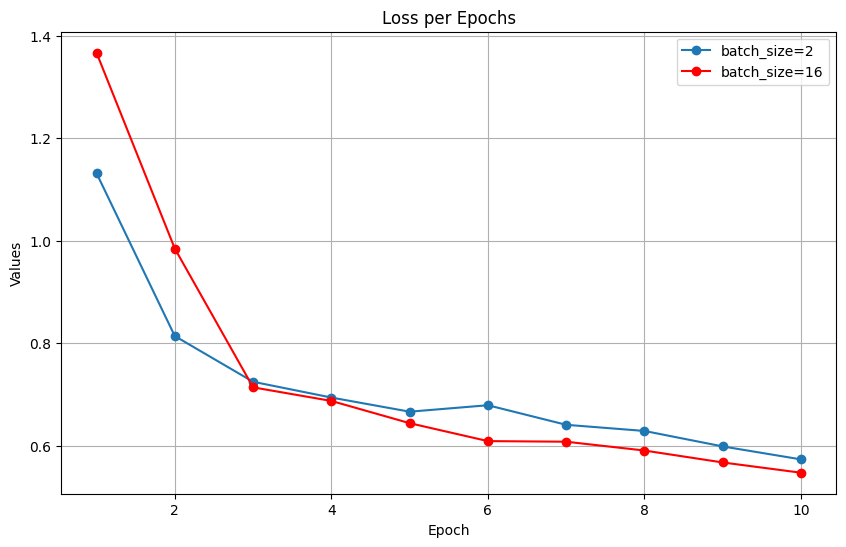

In [1]:
import matplotlib.pyplot as plt
epochs = range(1, 11)

batch_size2_loss = [
    1.132, 0.8141, 0.7249, 0.6941,
    0.6665, 0.6791, 0.6409, 0.6289,
    0.5987, 0.5734]
batch_size16_loss = [
    1.367, 0.9849, 0.714, 0.6875,
    0.6441, 0.6091, 0.6079, 0.5907,
    0.5674, 0.5474]

# 하나의 그래프에 여러 지표 그리기
plt.figure(figsize=(10, 6))

# 각 지표를 하나의 그래프에 그리기
plt.plot(epochs, batch_size2_loss, label="batch_size=2", marker='o')
plt.plot(epochs, batch_size16_loss, label="batch_size=16", marker='o', color='red')


# 그래프 설정
plt.xlabel('Epoch')
plt.ylabel('Values')
plt.title('Loss per Epochs')
plt.legend()
plt.grid(True)

# 그래프 출력
plt.show()


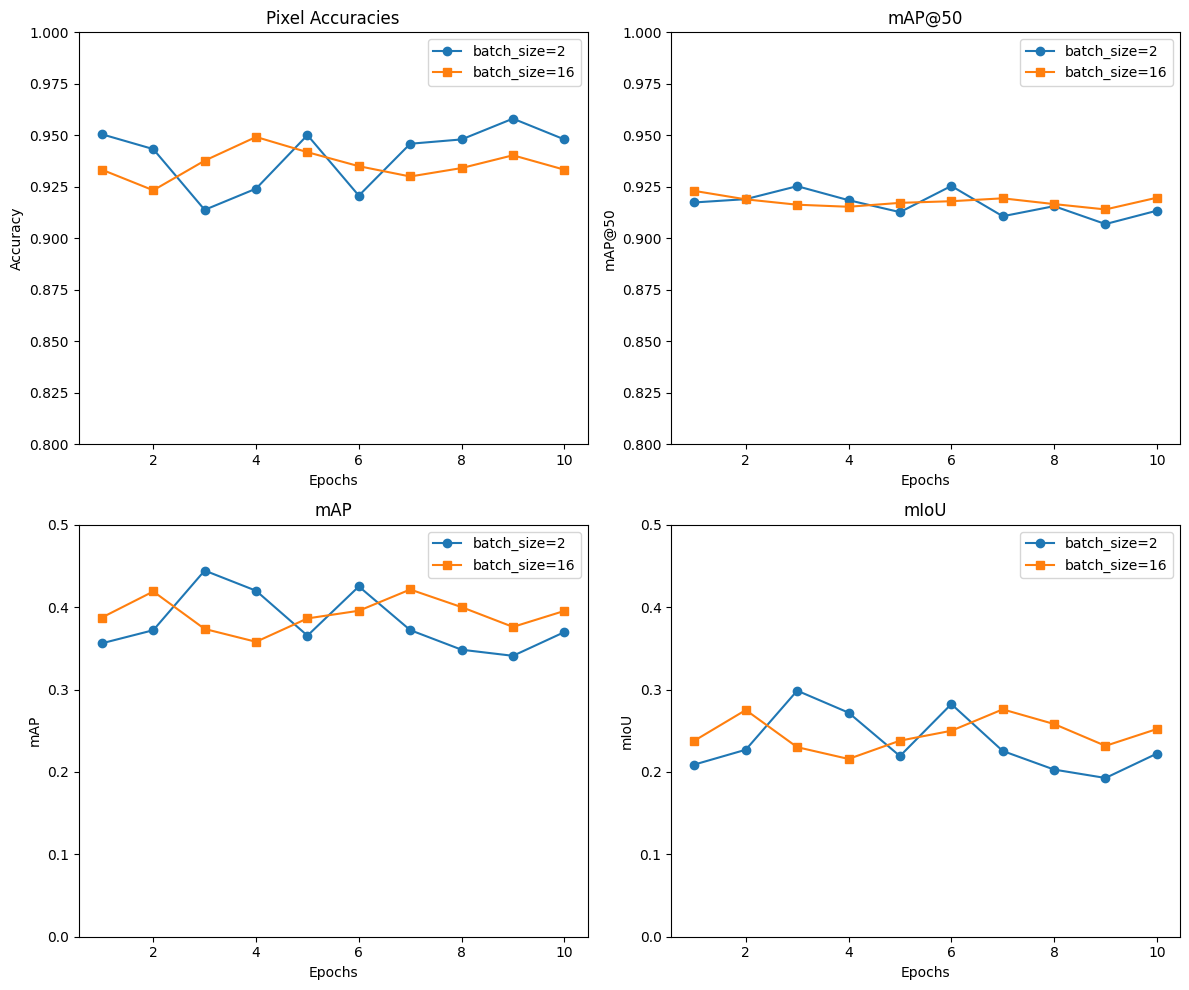

In [3]:
import matplotlib.pyplot as plt

# 데이터 준비
epochs = range(1, 11)

pixel_accuracies_batch2 =[0.9505, 0.9433, 0.9138, 0.9241, 0.9501, 0.9207, 0.9459, 0.9480, 0.9581, 0.9480]
map_50_values_batch2 =[0.9174, 0.9190, 0.9253, 0.9185, 0.9127, 0.9254, 0.9107, 0.9156, 0.9069, 0.9134]
map_values_batch2 =[0.3562, 0.3721, 0.4445, 0.4200, 0.3655, 0.4252, 0.3722, 0.3484, 0.3410, 0.3698]
miou_values_batch2 =[0.2090, 0.2270, 0.2987, 0.2720, 0.2193, 0.2824, 0.2255, 0.2029, 0.1927, 0.2223]

pixel_accuracies_batch16 =[0.9333, 0.9233, 0.9377, 0.9492, 0.9418, 0.9350, 0.9300, 0.9341, 0.9403, 0.9333]
map_50_values_batch16 =[0.9230, 0.9189, 0.9163, 0.9153, 0.9172, 0.9180, 0.9194, 0.9166, 0.9140, 0.9197]
map_values_batch16 =[0.3875, 0.4191, 0.3736, 0.3580, 0.3864, 0.3957, 0.4215, 0.4001, 0.3761, 0.3955]
miou_values_batch16 =[0.2380, 0.2752, 0.2301, 0.2158, 0.2380, 0.2500, 0.2760, 0.2582, 0.2317, 0.2521]

# 그래프 생성
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Pixel Accuracies
axs[0, 0].plot(epochs, pixel_accuracies_batch2, label="batch_size=2", marker='o')
axs[0, 0].plot(epochs, pixel_accuracies_batch16, label="batch_size=16", marker='s')
axs[0, 0].set_title('Pixel Accuracies')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].set_ylim(0.8, 1.0)
axs[0, 0].legend()

# mAP@50
axs[0, 1].plot(epochs, map_50_values_batch2, label="batch_size=2", marker='o')
axs[0, 1].plot(epochs, map_50_values_batch16, label="batch_size=16", marker='s')
axs[0, 1].set_title('mAP@50')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('mAP@50')
axs[0, 1].set_ylim(0.8, 1.0)
axs[0, 1].legend()

# mAP
axs[1, 0].plot(epochs, map_values_batch2, label="batch_size=2", marker='o')
axs[1, 0].plot(epochs, map_values_batch16, label="batch_size=16", marker='s')
axs[1, 0].set_title('mAP')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('mAP')
axs[1, 0].set_ylim(0.0, 0.5)
axs[1, 0].legend()

# mIoU
axs[1, 1].plot(epochs, miou_values_batch2, label="batch_size=2", marker='o')
axs[1, 1].plot(epochs, miou_values_batch16, label="batch_size=16", marker='s')
axs[1, 1].set_title('mIoU')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('mIoU')
axs[1, 1].set_ylim(0.0, 0.5)
axs[1, 1].legend()

plt.tight_layout()
plt.show()


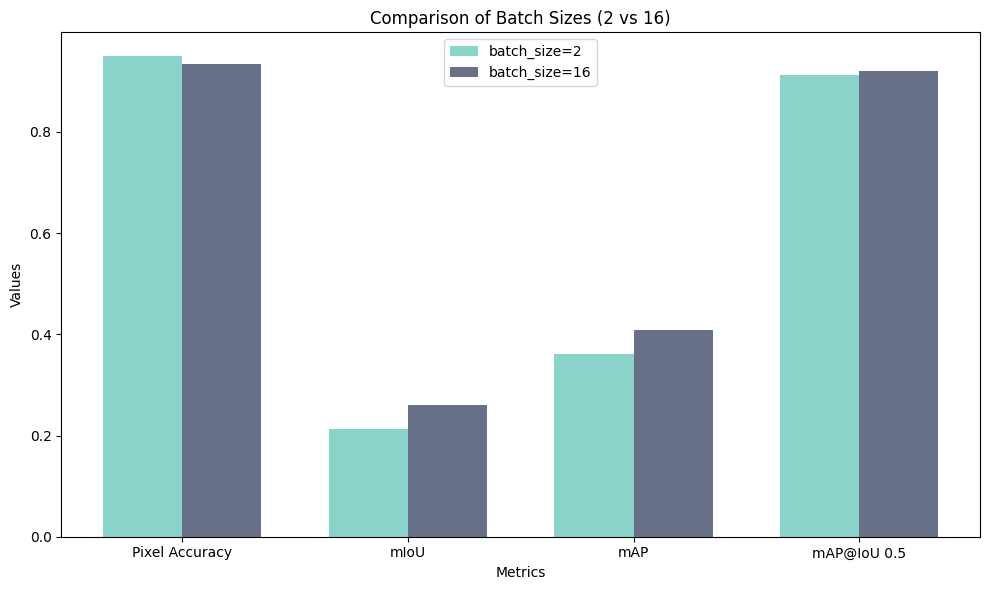

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# 데이터 준비
metrics = ['Pixel Accuracy', 'mIoU', 'mAP', 'mAP@IoU 0.5']
batch2_values = [0.949191249593236, 0.21377584196860283, 0.360550986247818, 0.9133298418790353]
batch16_values = [0.9342323812391788, 0.2600128181289443, 0.40754729579681187, 0.9201405249059731]

# 막대 그래프 생성
x = np.arange(len(metrics))  # 지표의 위치
width = 0.35  # 막대의 폭

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, batch2_values, width, label='batch_size=2', color='#8ad3cb')  # 연한 청록색
rects2 = ax.bar(x + width/2, batch16_values, width, label='batch_size=16', color='#687089')  # 진한 회색

# 그래프 레이블 추가
ax.set_xlabel('Metrics')
ax.set_ylabel('Values')
ax.set_title('Comparison of Batch Sizes (2 vs 16)')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# 그래프 표시
plt.tight_layout()
plt.show()


데이터셋 전처리 파일 병합
- 파일명을에 상위폴더번호까지 기입하여 해결
학습 결과 지표 오류
- 훈련데이터와 테스트데이터가 유사하여 새로운 테스트데이터 구축
- 배치사이즈 2에서 16으로 조정
Yolov8 로 증강시킨 일부 segmentation 오류
- num_class = 4(정확도가 높은car, person만 추가)로 조정
- 기존 bbox를 기반으로 num_class = 9까지 증강
일부의 프레임에서 주행공간을 자동차로 인식 
- 객체별 threshold값을 조정
이미지에서 사람앞뒤 공간을 주행공간으로 인식
- 서비스구현목표로 설정하여 일정거리내의 사람위에 경고표시 구현
영상에서 본넷을 자동차로 인식
- Opencv를 이용하여 본넷 segmentation을 제외

야간 데이터셋 증강\
데이터셋 주차장 비율 조정\
장애인 주차공간  개별 인식\
서비스와 성능 동시 향상을 위한 두 개의 모델 활용

## 5. 서비스 구현

### 5.1 서비스 개발 방향 설정

### 5.2 서비스 구현 코드

In [ ]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# Import common libraries
import numpy as np
import os, cv2, time
import torch
import json 

from detectron2.data.datasets import register_coco_instances
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor

# Define paths and parameters
config_file_path = "COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"
num_classes = 4  
device = "cuda"  # Or "cpu"

# Load configuration and create predictor
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(config_file_path))
cfg.MODEL.WEIGHTS = os.path.join("/home/elicer/detectron2_custom_dataset/output_yolo3/segmentation/model_final.pth")  # Path to your trained model
cfg.MODEL.ROI_HEADS.NUM_CLASSES = num_classes  # Set the number of classes (including background)
cfg.MODEL.DEVICE = device
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # Custom threshold

# 고정된 색상 설정
fixed_colors = {
    "Parking Space": (0, 255, 255),  # Yellow for Parking Space
    "Driveable Space": (0, 255, 0),  # Green for Driveable Space
    "car": (255, 0, 0),  # Blue for Car
    "person": (0, 0, 255)  # Red for Person
}

# Load bonnet coordinates from JSON file
with open("/home/elicer/hkheon/service/video2_bonnet_xy.json", "r") as f:
    bonnet_coords = json.load(f)["bonnet_coordinates"]

# Convert bonnet coordinates to a NumPy array for masking
bonnet_polygon = np.array(bonnet_coords, dtype=np.int32)

# Register custom dataset with a different name
DatasetCatalog.register("my_custom_dataset", lambda: get_custom_dataset_dicts("/home/elicer/dataset_sort/merged_labels_yolo/10020000.json"))
MetadataCatalog.get("my_custom_dataset").thing_classes = ["Parking Space", "Driveable Space", "car", "person"]

# 메타데이터를 초기화하고 색상 설정
metadata = MetadataCatalog.get("my_custom_dataset")
metadata.thing_colors = [fixed_colors[cls] for cls in metadata.thing_classes]

predictor = DefaultPredictor(cfg)

# Define paths for input and output videos
video_path = "/home/elicer/detectron2_custom_dataset/video/inference/video3.mp4"
output_video_path = "/home/elicer/detectron2_custom_dataset/video/service/result/video3_service_16_final.mp4"

# Distance calculation parameters
H_camera = 120  # 카메라의 실제 높이(cm)
focal_length = 500  # 카메라의 초점 거리(픽셀)
distance_threshold = 4  # 4미터 이내의 경우 경고 표시

# 비디오 캡처 객체 초기화
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print("Error opening video stream or file")
    exit()

# 비디오 코덱 및 저장을 위한 설정
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
fps = int(cap.get(cv2.CAP_PROP_FPS))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

# Define bonnet area to exclude
bonnet_threshold_y = int(height * 0.8)  # 하단 20%를 본넷 영역으로 설정

# 비디오 프로세싱 메인 루프
while cap.isOpened():
    start_time = time.time()  # 시작 시간 기록

    ret, frame = cap.read()  # 프레임 읽기
    if not ret:
        break  # 더 이상 읽을 프레임이 없으면 루프 탈출

    # 본넷 영역을 제외한 마스크 적용
    mask = np.zeros(frame.shape[:2], dtype="uint8")
    mask[:bonnet_threshold_y, :] = 255  # 상단 80%만 활성화

    # 현재 프레임에서 객체 탐지 수행
    masked_frame = cv2.bitwise_and(frame, frame, mask=mask)  # 본넷 부분을 제외한 프레임으로 예측 수행
    outputs = predictor(masked_frame)
    instances = outputs["instances"].to("cpu")

    # 주차공간 탐지를 위한 필터링
    parking_spaces = instances[instances.pred_classes == metadata.thing_classes.index("Parking Space")]

    # 신뢰도가 90 이상인 "Parking Space"만 필터링
    parking_spaces = parking_spaces[parking_spaces.scores > 0.9]
    num_parking_spaces = len(parking_spaces)

    # 결과 시각화 설정
    out_frame = frame.copy()

    for i in range(len(instances)):
        # 신뢰도 계산
        confidence = instances.scores[i].item() * 100  # 신뢰도 퍼센트로 변환

        # 특정 신뢰도 이상만 출력
        if confidence >= 90:
            mask = instances.pred_masks[i].numpy()
            cls_id = instances.pred_classes[i].item()
            label_text = metadata.thing_classes[cls_id]
            color = fixed_colors[label_text]

            # 마스크 색상으로 채우기
            colored_mask = np.zeros_like(out_frame)
            for c in range(3):
                colored_mask[:, :, c] = mask * color[c]

            # 본넷 좌표에 해당하는 부분을 제외한 마스크 적용
            cv2.fillPoly(colored_mask, [bonnet_polygon], (0, 0, 0))  # 본넷 좌표에 해당하는 부분은 검정색으로 덮어씀

            # 남아 있는 마스크 부분을 영상에 오버레이
            out_frame = cv2.addWeighted(out_frame, 1.0, colored_mask, 0.5, 0)

            # 본넷 영역과 겹치지 않는 부분만 남긴 마스크 생성
            mask_remained = mask.copy().astype(np.uint8)
            cv2.fillPoly(mask_remained, [bonnet_polygon], 0)  # 본넷 영역을 0으로 설정

            # 남아 있는 마스크를 기반으로 테두리 그리기
            contours, _ = cv2.findContours(mask_remained, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            cv2.drawContours(out_frame, contours, -1, color, 2)  # 테두리 추가

            # 라벨명과 신뢰도를 표시
            bbox = instances.pred_boxes[i].tensor.numpy().astype(int)[0]
            x, y = bbox[0], bbox[1]  # 좌상단 좌표
            text = f"{label_text}: {confidence:.1f}%"
            cv2.putText(out_frame, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, 1)  # 글씨 크기 줄임

    # FPS 계산
    end_time = time.time()
    elapsed_time = end_time - start_time
    fps = 1 / elapsed_time if elapsed_time > 0 else 0

    # FPS 및 주차 공간 수를 프레임에 표시
    cv2.putText(out_frame, f'FPS: {int(fps)}', (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
    cv2.putText(out_frame, f'Parking Spaces: {num_parking_spaces}', (20, 70), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

    # 신뢰도 90 이상인 주차공간 위에 화살표 그리기
    for box in parking_spaces.pred_boxes:
        x_center = int((box[0] + box[2]) / 2)
        y_top = int(box[1])

        arrow_start = (x_center, y_top - 10)
        arrow_end = (x_center, y_top + 20)

        cv2.arrowedLine(out_frame, arrow_start, arrow_end, (0, 255, 0), 2, tipLength=0.5)

    # 사람에 대한 거리 계산 및 시각화
    persons = instances[instances.pred_classes == metadata.thing_classes.index("person")]

    for i in range(len(persons)):
        bbox = persons.pred_boxes[i].tensor.numpy()[0]
        x1, y1, x2, y2 = bbox

        # y축 거리 계산 (사람의 바운딩 박스 높이)
        person_height_in_pixels = abs(y2 - y1)

        # 거리 계산
        distance = (H_camera * focal_length) / person_height_in_pixels
        distance_m = distance / 100  # cm를 m로 변환

        # 거리 정보 표시 제거
        xmid = (x1 + x2) / 2
        cv2.putText(out_frame, f'{distance_m:.2f} m', (int(xmid), int(y2)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)

        # 4미터 이내인 경우 큰 느낌표 표시
        if distance_m <= distance_threshold:
            # 사람 중심에 동그라미 배경을 갖는 느낌표 그리기
            center_x, center_y = int((x1 + x2) / 2), int((y1 + y2) / 2)
            radius = 30
            cv2.circle(out_frame, (center_x, center_y), radius, (255, 255, 255), -1)  # 흰색 배경

            # 느낌표 크기 조정 및 가운데 맞추기
            text_size = cv2.getTextSize('!', cv2.FONT_HERSHEY_SIMPLEX, 2, 4)[0]
            text_x = center_x - text_size[0] // 2
            text_y = center_y + text_size[1] // 2

            # 느낌표 표시
            cv2.putText(out_frame, '!', (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 4)

    # 수정된 프레임을 출력 비디오 파일에 저장
    out.write(out_frame)

cap.release()
out.release()
print("Video processing complete and resources released.")